# Books Recommendation system - Modeling
## Recommendation Engine with a) Collaborative Filtering and b) unsupervised learning
## Capstone Project Two : Springboard Data Science career track
### Notebook by Debisree Ray


### Acknowledgement:
* Mentor: Max Sop

* Springboard Team

* The data for this project originally comes from the GoodReads.com website. It was collected and made available by Zygmunt Zając on GitHub (https://github.com/zygmuntz/goodbooks-10k).


* Cover image: Internet

## 1. Introduction - The Problem:

Online recommendation systems are the ‘in’ thing to do for many e-commerce websites. A recommendation system broadly recommends products to customers best suited to their tastes and traits. This project is focused around building various kinds of book recommendation engines; namely the Simple Generic Recommender, the Content-Based Filter and the User-Based Collaborative Filter. The performance of the systems will be evaluated in both a qualitative and quantitative manner.

<img src="book.png" align="center" width="100%"/>

## 2. The Client:

Any E-commerce business website or online book-selling portal is the potential customer.

### 3. The Data:
The data is originally from the GoodReads.com website. It was collected and made available by Zygmunt Zając on GitHub (https://github.com/zygmuntz/goodbooks-10k).


* **'books.csv:'** 
   There are 10,000 books in this dataset. Descriptions of the columns are as follows: 

  * **books_count:** the number of editions for a given work.
  * **authors:** the authors(s) name.
  * **original_publication_year:** (9979 non-null)
  * **original_title:** (9415 non-null)
  * **title:** similar to original_title and includes the order it appears in a books series.
  * **language_code:** unclear if this is the language of the original edition or post popular edition. (8916 non-null, object)
  * **average_rating:** the mean rating out of 1-5 stars.
  * **ratings_count:** presumably, the number of unique users who have rated this book. It is lower than work_ratings_count.
  * **work_ratings_count:** number of total ratings a book received, may include multiple ratings per user?
  * **work_text_reviews_count:** number of written reviews, which is different than numerical ratings (number of stars).
  * **ratings_1:** number of 1-star ratings
  * **ratings_2:** number of 2-star ratings
  * **ratings_3:** number of 3-star ratings
  * **ratings_4:** number of 4-star ratings
  * **ratings_5:** number of 5-star ratings
  
* **'ratings.csv:'**
  On a scale of 1-5, how did the user rate a book? The list contains 5,976,479 book-user pairs and 53,424 unique users. The columns are as follows: 
  
  * **user_id:**
  * **book_id:**
  * **rating (1, 2, 3, 4, or 5):**

* **'to_read.csv:'** 
  Each entry represent a book that a user wants to read. There are 912,705 pair-wise entries. The columns are as follows: 
  
  * **user_id:**
  * **book_id:**

* **'tags.csv:'** 
  A list of user-created tags. These vary widely from genres to “16th-century” to “30-books-to-read-before-30”. There are 534,252 unique tag names. The columns are as follows: 
  
  * **tag_id:**
  * **tag_name:**

* **'book_tags.csv:'** 
   The number of times each tag was given to a specific book. The list contains 999,912 book-tag pairs. The columns are as follows: 
   * **goodreads_book_id:**
   * **tag_id:**
   * **count:**



### Collaborative Filtering:

in this section, we will use a technique called Collaborative Filtering to make recommendations to Goodread readers. Collaborative Filtering is based on the idea that users similar to me can be used to predict how much I would like a particular product or service those users have used/experienced but I have not.

Here we are using the **Surprise library** that uses extremely powerful algorithms like **Singular Value Decomposition (SVD)** to minimise the **RMSE (Root Mean Square Error**) and give great recommendations.

In [6]:
#Install the surprise library:

conda install -c conda-forge scikit-surprise

Solving environment: done

## Package Plan ##

  environment location: /Applications/anaconda3

  added / updated specs:
    - scikit-surprise


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py37_0         147 KB  conda-forge
    conda-4.7.12               |           py37_0         3.0 MB  conda-forge
    scikit-surprise-1.1.0      |py37heacc8b8_1001         597 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.7 MB

The following NEW packages will be INSTALLED:

  scikit-surprise    conda-forge/osx-64::scikit-surprise-1.1.0-py37heacc8b8_1001

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi                                         pkgs/main --> conda-forge
  conda                                           pkgs/main --> cond

In [75]:
import os
import math 
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from collections import defaultdict
from surprise import Reader, Dataset, NMF, SVD, NormalPredictor, BaselineOnly
from surprise import dump

from surprise.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from surprise import accuracy





#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

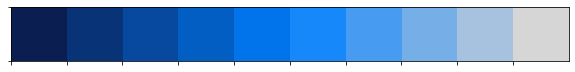

In [26]:
# Set chart defaults
fontsize = 14
figsize = (10,5)

# Define  colors
light_blue = '#007fff'
light_gray = '#d6d6d6'
dark_blue = '#133675'
dark_gray = '#696969'
darkest_blue = '#0b1e51'
darkest_gray = '#181818'

# Create Matplotlib colormap
def cmap(k, N=256):
    colors = (darkest_blue, light_blue, light_gray)
    return LinearSegmentedColormap.from_list('my_col', colors, N=max(N, 2))(k)

# Create Seaborn color palette
def palette(N):
    return np.asarray([cmap(k, N) for k in range(N)])

sns.palplot(sns.color_palette(palette(10)))

In [53]:
rate = pd.read_csv('ratings.csv')
rate.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [54]:
rate.shape

(5976479, 3)

In [28]:
rate['rating'].isnull().sum()

0

In [113]:
book= pd.read_csv('books.csv')
book.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [114]:
#Dropping the useless columns:

book=book.drop(['best_book_id','work_id','isbn13', 'image_url', 'small_image_url'], axis=1)
book.head()

,book_id,goodreads_book_id,books_count,isbn,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
0,1,2767052,272,439023483,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317
1,2,3,491,439554934,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543
2,3,41865,226,316015849,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439
3,4,2657,487,61120081,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267
4,5,4671,1356,743273567,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718


In [31]:
# load testset:

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rate[['user_id', 'book_id', 'rating']], reader)

#Algorithm= SVD:
svd = SVD()


#cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
# Train the algorithm on the trainset, and predict ratings for the testset:
trainset, testset = train_test_split(data, test_size=.25)
svd.fit(trainset)
predictions = svd.test(testset)


In [32]:
# Compute RMSE:
acc_svd=accuracy.rmse(predictions)
print('SVD Predictor RMSE:' + str(acc_svd))

RMSE: 0.8336
SVD Predictor RMSE:0.8336094036064619


In [46]:
rate[rate['user_id'] == 1]

,user_id,book_id,rating
0,1,258,5
75,1,268,3
76,1,5556,3
77,1,3638,3
78,1,1796,5
...,...,...,...
5704475,1,142,4
5704476,1,642,4
5704477,1,901,4
5704479,1,212,3


In [34]:
svd.predict(1, 231, 3)

Prediction(uid=1, iid=231, r_ui=3, est=3.527748746675314, details={'was_impossible': False})

So, For the book with book-ID 231, we get an estimated rating prediction of 3.39. One salient feature of this recommender system is that it doesn't care what the book is (or what it contains). It works purely on the basis of an assigned book-ID and tries to predict the ratings based on how the other users have predicted the book.

### Taking a random subset of the data : LowData

Next, I want to tune the SVD model. But with the entire dataset, it will be difficult to do that. So, I would take a random subset of the training data. And next will tune the model using the subset. And then used those tuned parameters for modeling with the actual dataset.

In [57]:
#Taking a small subset of the actual data:

low_rate=rate.sample(frac=0.001, random_state=43)
low_rate.shape

(5976, 3)

In [63]:
# Train the algorithm on the trainset, and predict ratings for the testset for the subset of the data:


reader = Reader(rating_scale=(1, 5))
lowdata = Dataset.load_from_df(low_rate[['user_id', 'book_id', 'rating']], reader)

#Algorithm= SVD:
svd = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset:
lowtrainset, lowtestset = train_test_split(lowdata, test_size=.25)
svd.fit(lowtrainset)
lowpredictions = svd.test(lowtestset)

# Compute RMSE:
acc_svd_low=accuracy.rmse(lowpredictions)
print('SVD Predictor RMSE:' + str(acc_svd_low))

RMSE: 0.9821
SVD Predictor RMSE:0.9820902440572827


In [65]:
# Tuning the SVD model:

param_grid = {'n_epochs': [15, 20], 'lr_all': [0.001, .005, 1],
              'reg_all': [0.1, 0.2, 0.4]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)


gs.fit(lowdata)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9939698350077563
{'n_epochs': 15, 'lr_all': 0.005, 'reg_all': 0.1}


### Fit best models on full dataset (without validation set)
Models: SVD and BaselineOnly with ALS
Accuracy metrics:
**RMSE (Root Mean Squared Error)**
**MAE (Mean Absolute Error)** MAE isn't affected as strongly as RMSE when there are a few large errors skewing the model's accuracy.


Okay. So, we have built another model with the low volume (or a random subset) of the data. And saw that the RMSE has increased for the small volume of the data.

Now, to tune the model, we have used the function **GridSearchCV** with cv =3. And got the best parameters as follows:

* **n_epochs: 15** The number of iteration of the SVD procedure. (Default is 20)
* **lr_all: 0.005** The learning rate for all parameters. (Default is 0.005)
* **reg_all: 0.01** The regularization term for all parameters. (Default is 0.02)

So, I would leverage these parameter values to train the full dataset, without the validation set.

In [67]:
# SVD model with bias:

# initiate a SVD algorithm object:

svd = SVD(n_epochs = 45, lr_all= 0.005, reg_all=0.1, biased=True)
svd.fit(trainset) # training on the trainset
pred_svd = svd.test(testset) # predict ratings for the testset
accuracy.rmse(pred_svd) # compute RMSE score

# user and item matrix with latent features
user_latent, item_latent = svd.pu, svd.qi
print(user_latent.shape, item_latent.shape)

RMSE: 0.8374
(53424, 100) (10000, 100)


In [68]:
accuracy.rmse(pred_svd), accuracy.mae(pred_svd)

RMSE: 0.8374
MAE:  0.6552


(0.8374069470415344, 0.655215324043431)

### Basic Algorithms:


* **NormalPredictor** is a random generator based on the distirbution of the training set.
* **BaselineOnly** gives estimate using the Alternating Least Squares (ALS)

In [14]:
# NormalPredictor model:

norm = NormalPredictor() 
norm.fit(trainset) 
predictions_norm = norm.test(testset) 

# Compute RMSE:
acc_norm= accuracy.rmse(predictions_norm)
print('Normal Predictor RMSE:' + str(acc_norm)) 

# BaselineOnly model with Alternating Least Squares (ALS):

base = BaselineOnly(bsl_options={}) 
base.fit(trainset) 
predictions_base = base.test(testset) 

# Compute RMSE:
acc_base= accuracy.rmse(predictions_base)
print('Baseline Predictor RMSE:' + str(acc_base)) 

RMSE: 1.3223
Normal Predictor RMSE:1.3223489147728729
Estimating biases using als...
RMSE: 0.8557
Baseline Predictor RMSE:0.8557498226291387


In [69]:
# Tuning NMF model:

param_grid = {'n_factors': [10, 15], 'n_epochs': [15, 20, 25],
              'biased': [True, False]}
gs = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(lowdata)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0097330950638033
{'n_factors': 10, 'n_epochs': 15, 'biased': True}


So, we have built a NMF model with the low volume (or a random subset) of the data. And saw that the RMSE has increased for the small volume of the data.

Now, to tune the model, we have used the function **GridSearchCV** with cv =5. And got the best parameters as follows:

* **n_factors: 10** The number of factors. (Default is 15)
* **n_epochs:15** The number of iteration of the SGD procedure. (Default is 50)
* **biased (bool): True** Whether to use baselines (or biases). (Default is False)

So, again, I would leverage these parameter values to train the full dataset, without the validation set.

In [71]:
# simple NMF model:

nmf = NMF(n_factors=10, n_epochs = 15, biased=True) # initiate a NMF algorithm object
nmf.fit(trainset) # training on the trainset
pred_nmf = nmf.test(testset) # predict ratings for the testset
accuracy.rmse(pred_nmf) # compute RMSE score

# user and item matrix with latent features:

mean = nmf.trainset.global_mean # global mean rating of the trainset
user_latent, item_latent = nmf.pu, nmf.qi
print(user_latent.shape, item_latent.shape)

RMSE: 0.8576
(53424, 10) (10000, 10)


In [76]:
# Save models and predictions:

dump.dump('./dump_SVD', pred_svd, svd)


### 3. Evaluate model performance:

Evaluation metrics: RMSE, MAE

In [77]:
predictions_svd, algo_svd = dump.load('./dump_SVD')
df_svd = pd.DataFrame(predictions_svd, columns=['uid', 'iid', 'rui', 'est', 'details']) 

### Build the Recommendation engine:


In [78]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


top_n = get_top_n(pred_svd, n=10)

In [80]:
# Print the recommended items for user id = 121:
# Prints the recommended Book-IDs and the ratings:


top_n[121]

[(3722, 3.9855427685066975),
 (459, 3.9170837208183316),
 (141, 3.864474392004926),
 (89, 3.851798865710452),
 (8353, 3.6757947724431514),
 (1460, 3.634883971633189),
 (1539, 3.625323660490741),
 (452, 3.585637413225873),
 (318, 3.5252283767929833),
 (137, 3.523586810402748)]

In [96]:
#Another example:

top_n[100]

[(6772, 3.9454120073195975),
 (9460, 3.747710353734171),
 (4862, 3.732061029526905),
 (786, 3.718174858223769),
 (11, 3.6812787948517944),
 (10, 3.6498790904489997),
 (3913, 3.637706679474103),
 (4531, 3.56757351514436),
 (2380, 3.539481081538475),
 (5911, 3.523850135698751)]

### Challenges around Collaboarative Filtering:

* Handling unknown/new users (Cold start problem)
* Data Sparsity
* Scalability - With large amount of data it is very difficult to execute the calculation or very time taking, given the limited computing fecility.
* To handle the dynamic updates - Let's say we have already built the model. Now if there is a new item, we have to rebuild the model. Which is definitely computationally /time expensive.(Eg. Google news: New news are coming out probably in every second of time.)

##  Using unsupervised learning:

To start with I will merge the two datasets.

In [115]:
# Let's merge the two tables:
# Merge the two tables then pivot so we have Users vs. Books dataframe:

ratings_title = pd.merge(rate, book[['book_id', 'title']], on='book_id' )
user_book_ratings = pd.pivot_table(ratings_title, index='user_id', columns= 'title', values='rating')

print('dataset dimensions: ', user_book_ratings.shape, '\n\nSubset example:')
user_book_ratings.iloc[:25, :10]

dataset dimensions:  (53424, 9964) 

Subset example:


title,"Angels (Walsh Family, #3)","""حكايات فرغلي المستكاوي ""حكايتى مع كفر السحلاوية",#GIRLBOSS,'Salem's Lot,"'Tis (Frank McCourt, #2)","1,000 Places to See Before You Die",1/4 جرام,"10% Happier: How I Tamed the Voice in My Head, Reduced Stress Without Losing My Edge, and Found Self-Help That Actually Works","100 Bullets, Vol. 1: First Shot, Last Call",100 Love Sonnets
user_id,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To reduce the sparseness of the matrix and to make it easier to work with, I will drop the books that have fewer than 300 ratings. In addition, I will drop the users who have provided fewer than 100 ratings on these books. This results in a matrix with 4,167 books (about 41% of the original) and 21,093 users (about 39% of the original).

In [116]:
# Drop books that have fewer than 300 ratings:

user_book_ratings = user_book_ratings.dropna(axis='columns', thresh=300)

# Drop users that have given fewer than 100 ratings of these most-rated books:

user_book_ratings = user_book_ratings.dropna(thresh=100)

print('dataset dimensions: ', user_book_ratings.shape, '\n\nSubset example:')
user_book_ratings.iloc[:25, :10]

dataset dimensions:  (21093, 4167) 

Subset example:


title,'Salem's Lot,"'Tis (Frank McCourt, #2)","1,000 Places to See Before You Die",100 Selected Poems,"10th Anniversary (Women's Murder Club, #10)",11/22/63,"11th Hour (Women's Murder Club, #11)","12th of Never (Women's Murder Club, #12)","13 Little Blue Envelopes (Little Blue Envelope, #1)",1491: New Revelations of the Americas Before Columbus
user_id,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, To reduce the dimensionality further, let us apply **truncated SVD**, which is available for the sparse matrices. Truncated Singular Value Decomposition (SVD) is a matrix factorization technique that factors a matrix M into the three matrices U, Σ, and V. This is very similar to PCA, excepting that the factorization for SVD is done on the data matrix, whereas for PCA, the factorization is done on the covariance matrix.

Let us use 200 features, these features will explain about 45 percent of the variance in the data.

In [117]:
# Import the package:

from sklearn.decomposition import TruncatedSVD

# replace NaN's with zeroes:
user_book_ratings_without_nan = user_book_ratings.fillna(0)
#user_book_ratings = user_book_ratings.fillna(0)

tsvd = TruncatedSVD(n_components=200, random_state=42)
user_book_ratings_tsvd = tsvd.fit(user_book_ratings_without_nan).transform(user_book_ratings_without_nan)

print('Original number of features:', user_book_ratings.shape[1])
print('Reduced number of features:', user_book_ratings_tsvd.shape[1])
print('Explained variance ratio:', tsvd.explained_variance_ratio_[0:200].sum())

Original number of features: 4167
Reduced number of features: 200
Explained variance ratio: 0.4578238713607182


In [118]:
 #view result in a Pandas dataframe:
indices = user_book_ratings.index

book_ratings_for_clustering = pd.DataFrame(data=user_book_ratings_tsvd).set_index(indices)
print('dataset dimensions: ', book_ratings_for_clustering.shape, '\n\nSubset example:')

book_ratings_for_clustering.head()

dataset dimensions:  (21093, 200) 

Subset example:


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
user_id,,,,,,,,,,,,,,,,,,,,,
1,15.890624,12.220122,1.925016,1.409163,-4.145488,-0.191061,-2.172195,1.114718,0.005334,-3.539271,...,-0.596701,0.921625,-0.245352,-2.351408,2.735142,1.599936,0.675483,0.355152,1.049572,-2.440467
4,23.520890,-3.361183,6.632460,-2.472390,-1.881259,-6.729464,-3.630784,-3.544545,-5.351490,4.873452,...,0.428251,-0.067155,-0.719930,0.035822,3.015869,-0.649941,2.061805,1.366151,1.468755,-0.701877
7,10.689776,-7.137688,7.228139,5.136675,-4.515555,4.123648,-1.091927,-2.580533,-3.603671,0.564154,...,-1.108762,0.022678,1.414898,0.524969,1.321435,-0.996483,1.085452,-0.687873,0.570073,0.783585
9,17.908101,3.201081,-2.745554,0.785079,-5.958210,-8.779004,-0.560748,-0.923265,-4.500548,-0.840713,...,-0.749163,0.072616,-0.575398,-1.831827,-0.049669,0.021070,0.880373,-0.037566,0.556280,-1.211235
10,15.556781,8.111153,1.614511,2.272684,-6.314662,-0.778649,-1.414877,-0.052674,1.193868,-2.328450,...,0.825325,-0.409831,0.623206,0.580134,1.181082,0.661408,-1.082637,3.318419,0.645057,0.934276


Now, let us split this dataframe into train-test set.

In [119]:
from sklearn.model_selection import train_test_split
book_ratings_training, book_ratings_testing = train_test_split(book_ratings_for_clustering, test_size=0.20, random_state=42)

print('Training data shape: ', book_ratings_training.shape)
print('Testing data shape: ', book_ratings_testing.shape)

Training data shape:  (16874, 200)
Testing data shape:  (4219, 200)


### Benchmark model:

The objective of the book recommendation engine is to recommend books a person hasn't read. However, evaluating the quality of these recommendations will be difficult without the opportunity to wait for readers to read the book and return with feedback. Therefore, I will need to take a different approach when comparing the quality of my recommendations to those of a benchmark model.

For each reader in a test set, I will calculate a benchmark by picking at random 10 books the person has rated and averaging the individual's ratings for those books. Then after clustering, I will find the 10 books the reader has read that his or her cluster rated the highest and calculated the reader's average score for those books. Finally, I will compare the average reader's rating for the recommended books to the reader's average rating for the randomly chosen books. I anticipate that the person will give higher ratings to the cluster's favorite books.

In [121]:
# find the per-book ratings of the test set
indices = book_ratings_testing.index
test_set_ratings = user_book_ratings.ix[indices]
test_set_ratings.head()

title,'Salem's Lot,"'Tis (Frank McCourt, #2)","1,000 Places to See Before You Die",100 Selected Poems,"10th Anniversary (Women's Murder Club, #10)",11/22/63,"11th Hour (Women's Murder Club, #11)","12th of Never (Women's Murder Club, #12)","13 Little Blue Envelopes (Little Blue Envelope, #1)",1491: New Revelations of the Americas Before Columbus,...,Zodiac,Zoo,god is Not Great: How Religion Poisons Everything,الأسود يليق بك,الفيل الأزرق,تراب الماس,ساق البامبو,عزازيل,هيبتا,يوتوبيا
user_id,,,,,,,,,,,,,,,,,,,,,
13361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30375,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
mean_ratings_for_random_10 = []

# for each user, pick 10 books at random that the reader has rated and get the reader's average score for those books:

for index, row in test_set_ratings.iterrows():
    ratings_without_nas = row.dropna()
    random_10 = ratings_without_nas.sample(n=10)
    random_10_mean = random_10.mean()
    mean_ratings_for_random_10.append(random_10_mean)

# get the mean of the users' mean ratings for 10 random books each    
mean_benchmark_rating = sum(mean_ratings_for_random_10) / len(mean_ratings_for_random_10)

print('Mean rating for 10 random books per test user: ', mean_benchmark_rating)

Mean rating for 10 random books per test user:  3.886003792367852


### Clustering:

In [123]:
# trying with the training data after preprocessing 
from sklearn.cluster import KMeans

clusterer_KMeans = KMeans(n_clusters=7).fit(book_ratings_training)
preds_KMeans = clusterer_KMeans.predict(book_ratings_training)

from sklearn.metrics import silhouette_score
kmeans_score = silhouette_score(book_ratings_training, preds_KMeans)
print(kmeans_score)

0.044470497229030764


In [124]:
indices = book_ratings_training.index
preds = pd.DataFrame(data=preds_KMeans, columns=['cluster']).set_index(indices)
preds.head()

,cluster
user_id,
41190,5
12423,1
50999,0
18685,4
36751,6


### Cluster analysis:
Now that clusters have been defined, I will examine each cluster.

In [127]:
# get a list of the highest-rated books for each cluster:

def get_cluster_favorites(cluster_number):
    # create a list of cluster members
    cluster_membership = preds.index[preds['cluster'] == cluster_number].tolist()
    # build a dataframe of that cluster's book ratings
    cluster_ratings = user_book_ratings.ix[cluster_membership]
    # drop books that have fewer than 10 ratings by cluster members
    cluster_ratings = cluster_ratings.dropna(axis='columns', thresh=10)
    # find the cluster's mean rating overal and for each book
    means = cluster_ratings.mean(axis=0)
    # sort books by mean rating
    favorites = means.sort_values(ascending=False)
    return favorites

# for each cluster, determine the overall mean rating cluster members have given books
def get_cluster_mean(cluster_number):
    # create a list of cluster members
    cluster_membership = preds.index[preds['cluster'] == cluster_number].tolist()
    # create a version of the original ratings dataset that only includes cluster members
    cluster_ratings = rate[rate['user_id'].isin(cluster_membership)]
    # get the mean rating
    return cluster_ratings['rating'].mean()

In [128]:
#Cluster:0

cluster0_books_storted = get_cluster_favorites(0)
cluster0_mean = get_cluster_mean(0)

print('The cluster 0 mean is:', cluster0_mean)
cluster0_books_storted[0:10]

The cluster 0 mean is: 3.9416800405790835


title
The Complete Calvin and Hobbes                                                                                  4.806452
The Calvin and Hobbes Tenth Anniversary Book                                                                    4.720000
The Harry Potter Collection 1-4 (Harry Potter, #1-4)                                                            4.714286
It's a Magical World: A Calvin and Hobbes Collection                                                            4.714286
The Mortal Instruments Boxed Set: City of Bones; City of Ashes; City of Glass (The Mortal Instruments, #1-3)    4.700000
Beyond the Highland Mist (Highlander, #1)                                                                       4.700000
The Complete Novels                                                                                             4.687500
The Secret (Highlands' Lairds #1)                                                                               4.666667
Going Postal (Discworld, #

In [129]:
#Cluster:1

cluster1_books_storted = get_cluster_favorites(1)
cluster1_mean = get_cluster_mean(1)

print('The cluster 1 mean is:', cluster1_mean)
cluster1_books_storted[0:10]

The cluster 1 mean is: 3.8153626001347978


title
The Book of Mormon: Another Testament of Jesus Christ                      5.000000
Holy Bible: New International Version                                      4.866667
Words of Radiance (The Stormlight Archive, #2)                             4.800000
The Cat in the Hat and Other Dr. Seuss Favorites                           4.777778
The Paper Bag Princess                                                     4.769231
Complete Poems, 1904-1962                                                  4.750000
The Harry Potter Collection 1-4 (Harry Potter, #1-4)                       4.733333
Harry Potter Boxset (Harry Potter, #1-7)                                   4.693878
The Complete Poems of Emily Dickinson                                      4.666667
Dr. Seuss's Green Eggs and Ham: For Soprano, Boy Soprano, and Orchestra    4.642857
dtype: float64

In [130]:
#Cluster:2

cluster2_books_storted = get_cluster_favorites(2)
cluster2_mean = get_cluster_mean(2)

print('The cluster 2 mean is:', cluster2_mean)
cluster2_books_storted[0:10]

The cluster 2 mean is: 3.9630435792064267


title
The Hitchhiker's Guide to the Galaxy: A Trilogy in Four Parts            4.833333
The Complete Calvin and Hobbes                                           4.833333
The Case for Christ                                                      4.800000
Faefever (Fever, #3)                                                     4.785714
Dreamfever (Fever, #4)                                                   4.785714
J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings    4.756757
The Name of the Wind (The Kingkiller Chronicle, #1)                      4.743902
Worlds' End (The Sandman #8)                                             4.736842
Clockwork Princess (The Infernal Devices, #3)                            4.733333
The Burning Bridge (Ranger's Apprentice, #2)                             4.727273
dtype: float64

In [131]:
#Cluster:3


cluster3_books_storted = get_cluster_favorites(3)
cluster3_mean = get_cluster_mean(3)

print('The cluster 3 mean is:', cluster3_mean)
cluster3_books_storted[0:10]

The cluster 3 mean is: 3.9118177763775406


title
Harry Potter Boxset (Harry Potter, #1-7)                                                          4.822581
The Boys in the Boat: Nine Americans and Their Epic Quest for Gold at the 1936 Berlin Olympics    4.818182
Guess How Much I Love You                                                                         4.785714
Harry Potter and the Deathly Hallows (Harry Potter, #7)                                           4.758520
A Court of Mist and Fury (A Court of Thorns and Roses, #2)                                        4.737931
Words of Radiance (The Stormlight Archive, #2)                                                    4.736842
Acheron (Dark-Hunter #14)                                                                         4.735294
A Voice in the Wind (Mark of the Lion, #1)                                                        4.733333
The Book of Mormon: Another Testament of Jesus Christ                                             4.730769
Schindler's List               

In [132]:
#Cluster:4

cluster4_books_storted = get_cluster_favorites(4)
cluster4_mean = get_cluster_mean(4)

print('The cluster 4 mean is:', cluster4_mean)
cluster4_books_storted[0:10]

The cluster 4 mean is: 3.8510048008990325


title
It's a Magical World: A Calvin and Hobbes Collection             4.875000
Saga, Vol. 2 (Saga, #2)                                          4.857143
Saga, Vol. 3 (Saga, #3)                                          4.833333
The Complete Calvin and Hobbes                                   4.790323
The Calvin and Hobbes Tenth Anniversary Book                     4.760563
Shadowfever (Fever, #5)                                          4.750000
The Essential Calvin and Hobbes: A Calvin and Hobbes Treasury    4.718310
The Wake (The Sandman #10)                                       4.714286
Blood Song (Raven's Shadow, #1)                                  4.700000
The Constitution of the United States of America                 4.698113
dtype: float64

In [133]:
#Cluster:5


cluster5_books_storted = get_cluster_favorites(5)
cluster5_mean = get_cluster_mean(5)

print('The cluster 5 mean is:', cluster5_mean)
cluster5_books_storted[0:10]

The cluster 5 mean is: 3.8823187237375527


title
It's a Magical World: A Calvin and Hobbes Collection                           4.857143
The Harry Potter Collection 1-4 (Harry Potter, #1-4)                           4.825000
The Kindly Ones (The Sandman #9)                                               4.766667
Harry Potter Boxset (Harry Potter, #1-7)                                       4.764120
The Essential Calvin and Hobbes: A Calvin and Hobbes Treasury                  4.752941
Fool's Fate (Tawny Man, #3)                                                    4.750000
Brief Lives (The Sandman #7)                                                   4.750000
A Game of Thrones: The Graphic Novel, Vol. 1                                   4.730769
A Storm of Swords: Blood and Gold (A Song of Ice and Fire, #3: Part 2 of 2)    4.729730
I Shall Wear Midnight (Discworld, #38; Tiffany Aching, #4)                     4.727273
dtype: float64

In [134]:
#Cluster:6


cluster6_books_storted = get_cluster_favorites(6)
cluster6_mean = get_cluster_mean(6)

print('The cluster 6 mean is:', cluster6_mean)
cluster6_books_storted[0:10]

The cluster 6 mean is: 3.904887482419128


title
The Complete Calvin and Hobbes                                   4.923077
The Calvin and Hobbes Tenth Anniversary Book                     4.864865
Saga, Vol. 2 (Saga, #2)                                          4.800000
Saga, Vol. 1 (Saga, #1)                                          4.734694
Words of Radiance (The Stormlight Archive, #2)                   4.706977
Calvin and Hobbes                                                4.693182
It's a Magical World: A Calvin and Hobbes Collection             4.684211
The Essential Calvin and Hobbes: A Calvin and Hobbes Treasury    4.675676
The Kindly Ones (The Sandman #9)                                 4.674419
The Wake (The Sandman #10)                                       4.638554
dtype: float64

So, here the clustering has been performed with 200 composite features. It is difficult to create a visualization that effectively illustrates all of these features. 
Therefore, let us  select the two top features, which played the most siginficant role in the clustering, and create a scatterplot that illustrates the clusters across those features.

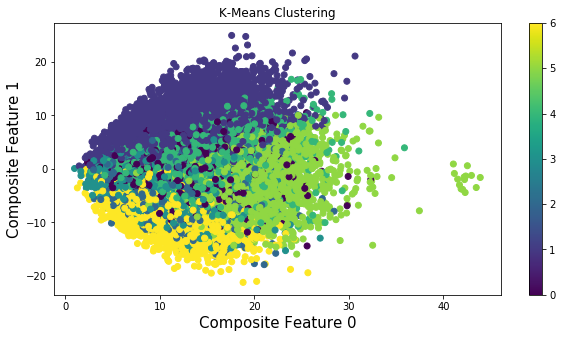

In [140]:
#Visually:



plt.figure(figsize=(10,5))

_= plt.scatter(book_ratings_training[0],book_ratings_training[1],c=preds_KMeans)
plt.title('K-Means Clustering',fontsize=12)
plt.xlabel('Composite Feature 0', fontsize=15)
plt.ylabel('Composite Feature 1',fontsize=15)
plt.colorbar()
plt.show()

In the scatterplot, a few distinct clusters are visible — especially cluster 5, depicted in light green. This indicates that the clustering model was effective in grouping users based on their values for composite features 0 and 1. The scatterplot also indicates that a few users had outlier values for composite feature 0.

### To build the Recommendation Engine:

In [142]:
# associate each test user with a cluster
test_set_preds = clusterer_KMeans.predict(book_ratings_testing)

test_set_indices = book_ratings_testing.index
test_set_clusters = pd.DataFrame(data=test_set_preds, columns=['cluster']).set_index(test_set_indices)




def recommend(cluster_assignments, ratings_matrix, user_id):
    user_cluster = cluster_assignments.loc[user_id, 'cluster']
    favorites = get_cluster_favorites(user_cluster).index
    for book in favorites:
        # check if the user's rating for the book is NaN. 
        #If so, recommend the book. Otherwise, the user has already read this book, so move on
        if np.isnan(ratings_matrix.loc[user_id, book]):
            return book
    return null

recommendation13361 = recommend(test_set_clusters, user_book_ratings, 13361)
recommendation31159 = recommend(test_set_clusters, user_book_ratings, 31159)
recommendation10579 = recommend(test_set_clusters, user_book_ratings, 10579)
recommendation30375 = recommend(test_set_clusters, user_book_ratings, 30375)

print('Recommendation for user 13361: ', recommendation13361)
print('Recommendation for user 31159: ', recommendation31159)
print('Recommendation for user 10579: ', recommendation10579)
print('Recommendation for user 30375: ', recommendation30375)

Recommendation for user 13361:  It's a Magical World: A Calvin and Hobbes Collection
Recommendation for user 31159:  The Complete Calvin and Hobbes
Recommendation for user 10579:  It's a Magical World: A Calvin and Hobbes Collection
Recommendation for user 30375:  The Book of Mormon: Another Testament of Jesus Christ
